In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from src.utils.fullSteinerSolverHyperbolic import isopticCurve, hyperbolicInnerAngleTriangle
from src.utils.steinerUtils import steinerPoint3
from src.utils.fullSteinerSolverEuclidean import equilateral_triangle
import matplotlib.lines as mlines
from pathlib import Path
import matplotlib.patches as patches


try:
    from phcpy.phcpy2c3 import py2c_set_seed
    ALLOW_PRECISE = True
    
except ModuleNotFoundError:
    ALLOW_PRECISE = False
    

def seed_all(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    if ALLOW_PRECISE:
        py2c_set_seed(seed)

seed_all(42)

FIG_PATH =  Path("./Figures/Results")



Is the phcpy2c3.so not suited for this platform?


In [13]:
def circumradius(x, y, Ux, Uy):
    """
    Calculate the circumradius given the circumcenter and a vertex.
    """
    return np.sqrt((x - Ux)**2 + (y - Uy)**2)

def circumcenter(x1, y1, x2, y2, x3, y3):
    """
    Calculate the circumcenter of a triangle given its three vertices.
    """
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    return Ux, Uy

def draw_circumcircle(ax, p1, p2, p3, c="tab:red"):
    """
    Draw the circumcircle and its arc given three vertices of a triangle.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    Ux, Uy = circumcenter(x1, y1, x2, y2, x3, y3)
    r = circumradius(x1, y1, Ux, Uy)

    # Plot the circumcircle
    circumcircle = plt.Circle((Ux, Uy), r, fill=False, color=c, linestyle=(5, (10, 8)))
    ax.add_artist(circumcircle)

    # Plot the arc from vertex 1 to vertex 2
    theta1 = np.arctan2(y1 - Uy, x1 - Ux)
    theta2 = np.arctan2(y2 - Uy, x2 - Ux)
    if theta2 < theta1:
        theta2 += 2 * np.pi

    p = (Ux + r*np.cos((theta1+theta2)/2), Uy + r*np.sin((theta1+theta2)/2))
    if np.all(np.isclose(p, [x3, y3])):
        aux = theta1
        theta1 = theta2
        theta2 = aux

    # Convert angles to degrees
    theta1 = np.degrees(theta1)
    theta2 = np.degrees(theta2)

    # Plot the arc using matplotlib.patches.Arc
    arc = patches.Arc((Ux, Uy), 2 * r, 2 * r, theta1=theta1, theta2=theta2, color=c)
    ax.add_patch(arc)

In [4]:
def polyIso(p, q, s, model="Klein"):
    a, b = p
    c, d = q
    x, y = s
    
    if model=="Klein":
        eq = 3*a**2*c**2*y**4 - 6*a**2*c**2*y**2 + 3*a**2*c**2 - 6*a**2*c*d*x*y**3 +\
                6*a**2*c*d*x*y + 6*a**2*c*x*y**2 - 6*a**2*c*x + 3*a**2*d**2*x**2*y**2 +\
                a**2*d**2*x**2 + a**2*d**2*y**2 - a**2*d**2 - 8*a**2*d*x**2*y -\
                2*a**2*d*y**3 + 2*a**2*d*y + a**2*x**2*y**2 + 3*a**2*x**2 +\
                a**2*y**4 - a**2*y**2 - 6*a*b*c**2*x*y**3 + 6*a*b*c**2*x*y +\
                12*a*b*c*d*x**2*y**2 - 8*a*b*c*d*x**2 - 8*a*b*c*d*y**2 + 8*a*b*c*d -\
                4*a*b*c*x**2*y + 8*a*b*c*y**3 - 8*a*b*c*y - 6*a*b*d**2*x**3*y +\
                6*a*b*d**2*x*y + 8*a*b*d*x**3 - 4*a*b*d*x*y**2 - 8*a*b*d*x - 2*a*b*x**3*y -\
                2*a*b*x*y**3 + 8*a*b*x*y + 6*a*c**2*x*y**2 - 6*a*c**2*x - 4*a*c*d*x**2*y +\
                8*a*c*d*y**3 - 8*a*c*d*y - 8*a*c*x**2*y**2 + 12*a*c*x**2 - 8*a*c*y**4 +\
                8*a*c*y**2 - 2*a*d**2*x**3 - 8*a*d**2*x*y**2 + 2*a*d**2*x + 8*a*d*x**3*y +\
                8*a*d*x*y**3 + 4*a*d*x*y - 6*a*x**3 - 6*a*x*y**2 + 3*b**2*c**2*x**2*y**2 +\
                b**2*c**2*x**2 + b**2*c**2*y**2 - b**2*c**2 - 6*b**2*c*d*x**3*y +\
                6*b**2*c*d*x*y - 2*b**2*c*x**3 - 8*b**2*c*x*y**2 + 2*b**2*c*x +\
                3*b**2*d**2*x**4 - 6*b**2*d**2*x**2 + 3*b**2*d**2 + 6*b**2*d*x**2*y -\
                6*b**2*d*y + b**2*x**4 + b**2*x**2*y**2 - b**2*x**2 + 3*b**2*y**2 -\
                8*b*c**2*x**2*y - 2*b*c**2*y**3 + 2*b*c**2*y + 8*b*c*d*x**3 -\
                4*b*c*d*x*y**2 - 8*b*c*d*x + 8*b*c*x**3*y + 8*b*c*x*y**3 + 4*b*c*x*y +\
                6*b*d**2*x**2*y - 6*b*d**2*y - 8*b*d*x**4 - 8*b*d*x**2*y**2 +\
                8*b*d*x**2 + 12*b*d*y**2 - 6*b*x**2*y - 6*b*y**3 + c**2*x**2*y**2 +\
                3*c**2*x**2 + c**2*y**4 - c**2*y**2 - 2*c*d*x**3*y - 2*c*d*x*y**3 +\
                8*c*d*x*y - 6*c*x**3 - 6*c*x*y**2 + d**2*x**4 + d**2*x**2*y**2 -\
                d**2*x**2 + 3*d**2*y**2 - 6*d*x**2*y - 6*d*y**3 + 3*x**4 + 6*x**2*y**2 + 3*y**4
    
    elif model == "Half":
        eq = 3*a**4*c**4 - 12*a**4*c**3*x + 6*a**4*c**2*d**2 + 18*a**4*c**2*x**2 -\
                10*a**4*c**2*y**2 - 12*a**4*c*d**2*x - 12*a**4*c*x**3 + 20*a**4*c*x*y**2 +\
                3*a**4*d**4 + 6*a**4*d**2*x**2 - 6*a**4*d**2*y**2 + 3*a**4*x**4 - 10*a**4*x**2*y**2 +\
                3*a**4*y**4 - 12*a**3*c**4*x + 48*a**3*c**3*x**2 + 32*a**3*c**3*y**2 -\
                24*a**3*c**2*d**2*x - 72*a**3*c**2*x**3 - 56*a**3*c**2*x*y**2 + 48*a**3*c*d**2*x**2 +\
                32*a**3*c*d**2*y**2 + 48*a**3*c*x**4 + 16*a**3*c*x**2*y**2 - 32*a**3*c*y**4 -\
                12*a**3*d**4*x - 24*a**3*d**2*x**3 - 8*a**3*d**2*x*y**2 - 12*a**3*x**5 +\
                8*a**3*x**3*y**2 + 20*a**3*x*y**4 + 6*a**2*b**2*c**4 - 24*a**2*b**2*c**3*x +\
                12*a**2*b**2*c**2*d**2 + 36*a**2*b**2*c**2*x**2 - 20*a**2*b**2*c**2*y**2 -\
                24*a**2*b**2*c*d**2*x - 24*a**2*b**2*c*x**3 + 40*a**2*b**2*c*x*y**2 +\
                6*a**2*b**2*d**4 + 12*a**2*b**2*d**2*x**2 - 12*a**2*b**2*d**2*y**2 + 6*a**2*b**2*x**4 -\
                20*a**2*b**2*x**2*y**2 + 6*a**2*b**2*y**4 + 18*a**2*c**4*x**2 - 10*a**2*c**4*y**2 -\
                72*a**2*c**3*x**3 - 56*a**2*c**3*x*y**2 + 36*a**2*c**2*d**2*x**2 -\
                20*a**2*c**2*d**2*y**2 + 108*a**2*c**2*x**4 + 168*a**2*c**2*x**2*y**2 +\
                76*a**2*c**2*y**4 - 72*a**2*c*d**2*x**3 - 56*a**2*c*d**2*x*y**2 -\
                72*a**2*c*x**5 - 128*a**2*c*x**3*y**2 - 56*a**2*c*x*y**4 + 18*a**2*d**4*x**2 -\
                10*a**2*d**4*y**2 + 36*a**2*d**2*x**4 + 40*a**2*d**2*x**2*y**2 +\
                20*a**2*d**2*y**4 + 18*a**2*x**6 + 26*a**2*x**4*y**2 - 2*a**2*x**2*y**4 -\
                10*a**2*y**6 - 12*a*b**2*c**4*x + 48*a*b**2*c**3*x**2 + 32*a*b**2*c**3*y**2 -\
                24*a*b**2*c**2*d**2*x - 72*a*b**2*c**2*x**3 - 56*a*b**2*c**2*x*y**2 +\
                48*a*b**2*c*d**2*x**2 + 32*a*b**2*c*d**2*y**2 + 48*a*b**2*c*x**4 +\
                16*a*b**2*c*x**2*y**2 - 32*a*b**2*c*y**4 - 12*a*b**2*d**4*x - 24*a*b**2*d**2*x**3 -\
                8*a*b**2*d**2*x*y**2 - 12*a*b**2*x**5 + 8*a*b**2*x**3*y**2 + 20*a*b**2*x*y**4 -\
                12*a*c**4*x**3 + 20*a*c**4*x*y**2 + 48*a*c**3*x**4 + 16*a*c**3*x**2*y**2 -\
                32*a*c**3*y**4 - 24*a*c**2*d**2*x**3 + 40*a*c**2*d**2*x*y**2 - 72*a*c**2*x**5 -\
                128*a*c**2*x**3*y**2 - 56*a*c**2*x*y**4 + 48*a*c*d**2*x**4 + 16*a*c*d**2*x**2*y**2 -\
                32*a*c*d**2*y**4 + 48*a*c*x**6 + 128*a*c*x**4*y**2 + 112*a*c*x**2*y**4 + 32*a*c*y**6 -\
                12*a*d**4*x**3 + 20*a*d**4*x*y**2 - 24*a*d**2*x**5 - 32*a*d**2*x**3*y**2 - 8*a*d**2*x*y**4 -\
                12*a*x**7 - 36*a*x**5*y**2 - 36*a*x**3*y**4 - 12*a*x*y**6 + 3*b**4*c**4 -\
                12*b**4*c**3*x + 6*b**4*c**2*d**2 + 18*b**4*c**2*x**2 - 10*b**4*c**2*y**2 -\
                12*b**4*c*d**2*x - 12*b**4*c*x**3 + 20*b**4*c*x*y**2 + 3*b**4*d**4 + 6*b**4*d**2*x**2 -\
                6*b**4*d**2*y**2 + 3*b**4*x**4 - 10*b**4*x**2*y**2 + 3*b**4*y**4 + 6*b**2*c**4*x**2 -\
                6*b**2*c**4*y**2 - 24*b**2*c**3*x**3 - 8*b**2*c**3*x*y**2 + 12*b**2*c**2*d**2*x**2 -\
                12*b**2*c**2*d**2*y**2 + 36*b**2*c**2*x**4 + 40*b**2*c**2*x**2*y**2 + 20*b**2*c**2*y**4 -\
                24*b**2*c*d**2*x**3 - 8*b**2*c*d**2*x*y**2 - 24*b**2*c*x**5 - 32*b**2*c*x**3*y**2 -\
                8*b**2*c*x*y**4 + 6*b**2*d**4*x**2 - 6*b**2*d**4*y**2 + 12*b**2*d**2*x**4 +\
                8*b**2*d**2*x**2*y**2 + 12*b**2*d**2*y**4 + 6*b**2*x**6 + 6*b**2*x**4*y**2 -\
                6*b**2*x**2*y**4 - 6*b**2*y**6 + 3*c**4*x**4 - 10*c**4*x**2*y**2 + 3*c**4*y**4 -\
                12*c**3*x**5 + 8*c**3*x**3*y**2 + 20*c**3*x*y**4 + 6*c**2*d**2*x**4 -\
                20*c**2*d**2*x**2*y**2 + 6*c**2*d**2*y**4 + 18*c**2*x**6 + 26*c**2*x**4*y**2 -\
                2*c**2*x**2*y**4 - 10*c**2*y**6 - 12*c*d**2*x**5 + 8*c*d**2*x**3*y**2 + 20*c*d**2*x*y**4 -\
                12*c*x**7 - 36*c*x**5*y**2 - 36*c*x**3*y**4 - 12*c*x*y**6 + 3*d**4*x**4 -\
                10*d**4*x**2*y**2 + 3*d**4*y**4 + 6*d**2*x**6 + 6*d**2*x**4*y**2 - 6*d**2*x**2*y**4 -\
                6*d**2*y**6 + 3*x**8 + 12*x**6*y**2 + 18*x**4*y**4 + 12*x**2*y**6 + 3*y**8

    else:
        raise ValueError("model should be either 'Klein' or 'Half'")
    
    return eq

In [5]:
def drawIsoptic(p1, p2, p3, poly=False, space="Klein", dist2Points=1e-5, precise=True, borders=None):
    
    precise = precise and ALLOW_PRECISE
    
    point = steinerPoint3([p1, p2, p3], model=space, dist2Points=dist2Points, precise=precise)
    print(point)
    
    
    fig = plt.figure(figsize=(5,5), dpi=200)
    ax = fig.add_subplot(111, aspect='equal')

         
    
    if space in ["Klein", "Half"]:
        if space=="Klein":
            X,Y = np.meshgrid(np.linspace(-1.15, 1.15, 500),
                        np.linspace(-1.15, 1.15, 500))
        else:
            if borders is None:
                borders = [1 if not poly else 5]*2

            minX = min([p1[0], p2[0], p3[0]]) - borders[0]
            maxX = max([p1[0], p2[0], p3[0]]) + borders[0]
            maxY = max([p1[1], p2[1], p3[1]]) + borders[1]
            X,Y = np.meshgrid(np.linspace(minX, maxX, 1000),
                        np.linspace(-maxY, maxY, 1000))
            
            
        if poly:
            ax.contour(X,Y,  polyIso(p1, p2, [X, Y], model=space), 0, colors="tab:green", zorder=1, linestyles="dashed")
            ax.contour(X,Y,  polyIso(p2, p3, [X, Y], model=space), 0, colors="tab:red", zorder=1,  linestyles="dashed")

        else:
            ax.contour(X,Y, isopticCurve(p1, p3, [X, Y], model=space), 0, colors="tab:blue", zorder=1)

        ax.contour(X,Y,  isopticCurve(p1, p2, [X, Y], model=space), 0, colors="tab:green", zorder=2)
        ax.contour(X,Y,  isopticCurve(p2, p3, [X, Y], model=space), 0, colors="tab:red", zorder=2)

        if space=="Klein":
            circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
            ax.add_patch(circ)
        else:
            ax.axhspan(0, maxY, facecolor='lavender', alpha=0.5, zorder=0)
        
            
    
    elif space=="Euclidean":
        colors = ["tab:green", "tab:red", "tab:blue"]
        vertices = [p1, p2, p3]
        for i, c in enumerate(colors):
            v1 = vertices[i]
            v2 = vertices[(i+1)%3]
            v3 = vertices[(i+2)%3]
            equilateral_point = equilateral_triangle(v1, v2, v3)
            triangle = plt.Polygon([v1, v2, equilateral_point], fill=True, color='grey', alpha=0.3)
            ax.add_artist(triangle)
            draw_circumcircle(ax, v1, v2, equilateral_point, c=c)
        

    if point is not None:
        ax.scatter(point[0], point[1],  marker="*", c="black",s =265, edgecolors="white", zorder=10)

    ax.scatter(p1[0], p1[1],  marker="s", c="black",s =60, edgecolors="white", zorder=10)
    ax.scatter(p2[0], p2[1],  marker="s", c="black",s =60, edgecolors="white",  zorder=10)
    ax.scatter(p3[0], p3[1],  marker="s", c="black",s =60, edgecolors="white", zorder=10)
    
    if space in ["Klein"]:
        
        plt.legend(handles=[
                    mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                        markersize=10, label='Steiner'),

                    mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                                        markersize=7, label='Terminal')
                    ],
                   loc='upper right',
                   bbox_to_anchor=(1.10, 1)
                  )

    if space=="Half":
        # Move left y-axis and bottom x-axis to centre, passing through (0,0)
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.set_yticks([])
        ax.set_xticks([])


    else:
        ax.axis('off')
    
    fig.tight_layout()

    filename = f"isoptics_{space}" if not poly else f"polySys_{space}"
    fig.savefig(FIG_PATH / f"{filename}.png")

    plt.show()

    return point

[0.64916135 4.25496121]


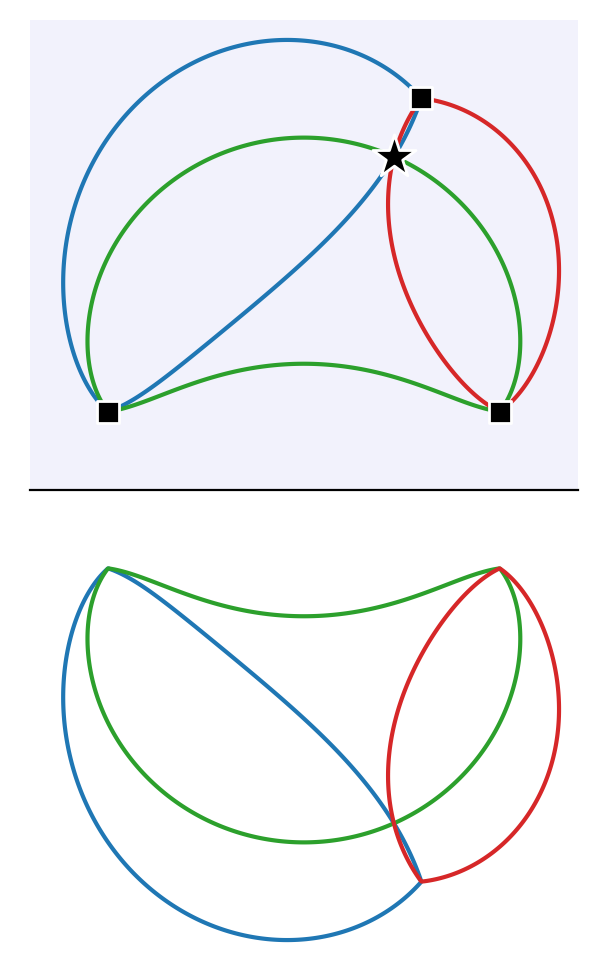

In [118]:
p1 = np.array([-3, 1])
p2 = np.array([2, 1])
p3 = np.array([1,5])

drawIsoptic(p1, p2, p3, poly=False, space="Half", dist2Points=1e-5, precise=False, borders=[1, 1]);

[-0.12575112  0.29362299]


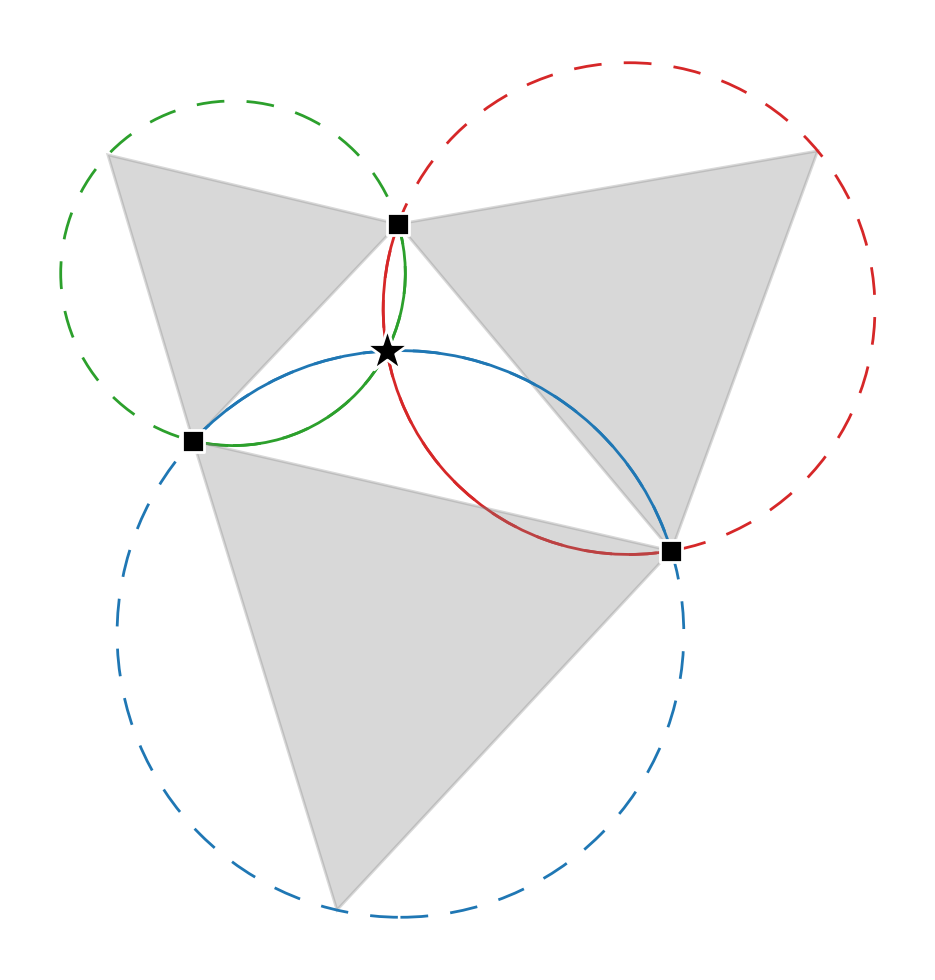

In [15]:
p1 = np.array([-0.70, 0.02705193])
p2 = np.array([-0.09223223, 0.66927742])
p3 = np.array([0.7170893,-0.29871065])

drawIsoptic(p1, p2, p3, poly=False, space="Euclidean", dist2Points=1e-5);